In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
from gdalconst import * 

import sys, os, time

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from IPython.display import clear_output

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

## Load data in GeoTiff format

Let's look at the VIIRS data of night lights. This data is acquired monthly and is available since 2012. The spatial resolution is $0.5 \ km^2/px$.
The data is provided as a set of 6 tiles that span most of the globe (two files per tile).

In [2]:
# list of files 

# files = """http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060E_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060E_vcmcfg_v10_c201610280941.tgz""".split("\n")

In [5]:
import glob, os
rast_files = glob.glob("/home/data/VIIRS/2015/*vcm_v10*.avg_rade9.tif")
print len(rast_files)

6


In [6]:
rast_files

['/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_75N180W_vcm_v10_c201701311200.avg_rade9.tif',
 '/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_75N060E_vcm_v10_c201701311200.avg_rade9.tif',
 '/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_00N060E_vcm_v10_c201701311200.avg_rade9.tif',
 '/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_75N060W_vcm_v10_c201701311200.avg_rade9.tif',
 '/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_00N060W_vcm_v10_c201701311200.avg_rade9.tif',
 '/home/data/VIIRS/2015/SVDNB_npp_20150101-20151231_00N180W_vcm_v10_c201701311200.avg_rade9.tif']

In [7]:
loc = (37.7749, -122.4194) # San Francisco lat/lon

### Helper utilities

In [8]:
import pysatml

Given a location (lat, lon) and a spatial area (width, height) in km, get the bounding box in degrees

In [10]:
bbox = pysatml.utils.gis_utils.bounding_box_at_location(loc, (100,100))
print bbox

(37.32517953888292, -122.98836144499806, 38.224620461117084, -121.85043855500192)


Get spatial dimensions of area (in degrees) at a given lat,lon location

In [11]:
geoSize = pysatml.utils.gis_utils.km_to_deg_at_location(loc, (100,100))
print geoSize

(0.899440922234163, 1.1379228899961475)


### Get images from from raster

Initialize client with either a raster file (GeoTiff format) or with a directory containing multiple such files. In the latter scenario, it is assumed that the files provide coverage of different geographical areas around the same time. 

In [12]:
# initialize client
simg = pysatml.satimage.SatImage(rast_files)

(0.002082733349993761, -180.00208333335016, 75.00208333335007, -60.002082373350035)
(0.002082733349993761, 59.997916666650056, 75.00208333335007, 179.99791762665018)
(-64.99791718665006, 59.997916666650056, 0.0020833333500000022, 179.99791762665018)
(0.002082733349993761, -60.002083333350065, 75.00208333335007, 59.99791762665007)
(-64.99791718665006, -60.002083333350065, 0.0020833333500000022, 59.99791762665007)
(-64.99791718665006, -180.00208333335016, 0.0020833333500000022, -60.002082373350035)


When no spatial width is given, assume the desired output is the pixel value at that the input location.

In [14]:
pixValue = simg.get_image_at_location(loc)
pixValue

array([ 94.81171417])

Get image of a given spatial extent $w$ (in $km$) at a given location $loc=(lat, lon)$

In [15]:
img = simg.get_image_at_location(loc, w=100) # a 10km x 10km window around the geographical center of San Francisco
img.shape

(1, 216, 273)

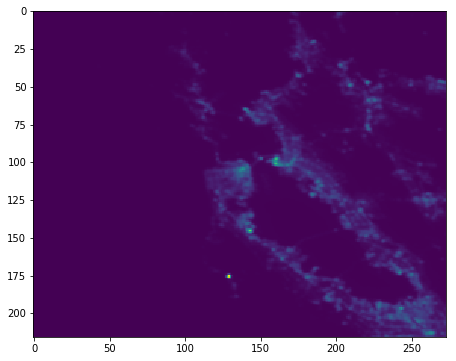

In [16]:
plt.figure(figsize=(8,6))
plt.imshow(img[0])

Obtain a few images for a number of cities around the world. Note that different locations may be in different raster files.

In [17]:
locs = ["San Francisco, CA", "Cambridge, MA", "Toronto, Canada", "Iasi, Romania", "Singapore", "Beijing, China"]

# obtaining the lat/lon coordinates via geocoding before the call is not needed

# import geocoder
# locs = [tuple(geocoder.google(l).latlng) for l in locs]
# locs

In [18]:
images = simg.get_image_at_locations(locs, w=100)

In [19]:
images.keys()

['Cambridge, MA',
 'Singapore',
 'Beijing, China',
 'Iasi, Romania',
 'Toronto, Canada',
 'San Francisco, CA']

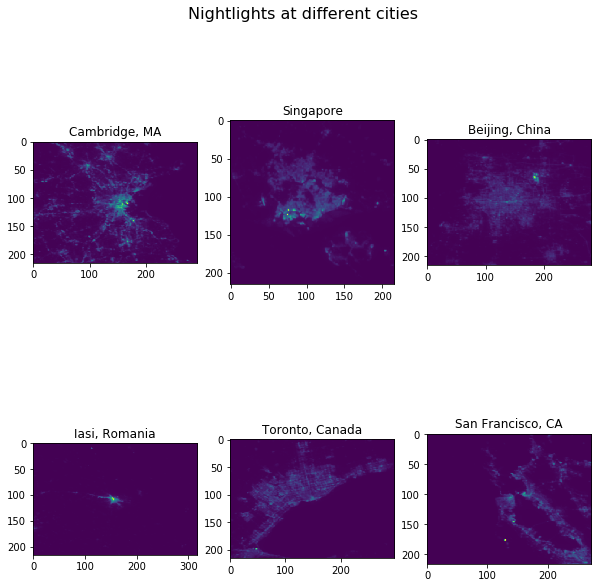

In [20]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Nightlights at different cities", fontsize=16)
for i,(k,v) in enumerate(images.iteritems()):
    ax = plt.subplot(2,3,i+1)
    ax.set_title(k)
    plt.imshow(v[0,:,:])
plt.show()

### Sample images around locations

Sample locations within a bounding box

In [21]:
bbox # 100km x 100km around San Francisco

(37.32517953888292,
 -122.98836144499806,
 38.224620461117084,
 -121.85043855500192)

In [22]:
sample_locs = pysatml.satimage.generate_locations_within_bounding_box(bbox, nSamples = 10)
print sample_locs

[(38.193982681578966, -122.95645204986621), (37.698281606092927, -122.96420109384799), (37.367653082136094, -122.94051339270911), (38.111253006113415, -122.27680610607079), (37.709462323607845, -122.32526906780647), (37.552718675186945, -122.32292314902662), (37.871238376330879, -121.91487871675307), (37.919760254934104, -122.40455965485985), (37.867732681227686, -122.13554998892805), (37.887497178285216, -122.79700774903338)]


Sample locations within a given polygon

In [23]:
from shapely.geometry import Polygon, Point
p = Polygon([(bbox[1], bbox[0]), ([bbox[1], bbox[2]]), (([bbox[3], bbox[2]])), ([bbox[3], bbox[0]])])

In [24]:
pysatml.satimage.generate_locations_within_polygon(p, 10)

[(-122.17951268255645, 38.135682052867892),
 (-122.81735742194688, 37.412415187441837),
 (-122.21487378008754, 37.347234815454854),
 (-122.13148772771582, 37.971487454108122),
 (-121.97392075767672, 38.108979222007839),
 (-121.91232354195131, 37.569873061156471),
 (-122.71100916227702, 37.492685492744236),
 (-122.2696724252921, 37.521506306517232),
 (-122.74532645001965, 37.84398242021841),
 (-122.0475994550898, 37.830694951946718)]

For San Francisco, sample 10km x 10km images within a 100km x 100km bounding box

In [25]:
sampleImages = simg.sample_images_around_location(loc, w=5, W=100, nSamples=10)

In [26]:
len(sampleImages)

10

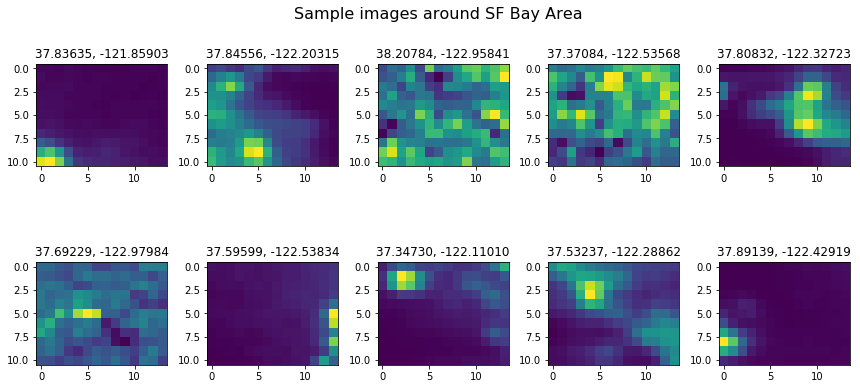

In [31]:
fig = plt.figure(figsize=(12,6))
fig.suptitle("Sample images around SF Bay Area", fontsize=16)
for i,(k,v) in enumerate(sampleImages.iteritems()):
    ax = plt.subplot(2,5,i+1)
    ax.set_title("%2.5f, %2.5f"%k)
    plt.imshow(v[0,:,:])
plt.tight_layout()
plt.show()

### Save sample images directly to file

Single image

In [160]:
simg.get_image_at_location(loc, w=100, dumpPath="./outpath/2016/")

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: ./outpath/2016//37.774900_-122.419400_100km.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Multiple images

In [161]:
locs

['San Francisco, CA',
 'Cambridge, MA',
 'Toronto, Canada',
 'Iasi, Romania',
 'Singapore',
 'Beijing, China']

In [35]:
img = simg.get_image_at_locations(locs, w=100, dumpPath="./sample-images/")

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: ./sample-images/47.158455_27.601442_100km.png is a low contrast image
  warn('%s is a low contrast image' % fname)
